<a href="https://colab.research.google.com/github/RaminParker/Text-Classification-with-Python/blob/master/Multiclass_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Master](https://github.com/robsalgado/personal_data_science_projects/blob/master/mulitclass_text_class/Multiclass%20Text%20Classification%20Notebook.ipynb)

[Interessant 1](https://www.kaggle.com/bbose71/bbc-news-classification/data)

[Interessant 2](https://www.kaggle.com/aryankaul31/aryan-bbc-news-classification)

[Interessant 3](https://www.kaggle.com/abbahaddou/bbc-automatic-document-classification)

[Multi-Class Text Classification Model Comparison and Selection](https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568)

In [31]:
import pandas as pd
import numpy as np

#Loading additional helper functions not shown here but provided in the folder
%run nlp_utils_news.ipynb

'''Features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

'''Metrics/Evaluation'''
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''Display'''
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

ERROR:root:File `'nlp_utils_news.ipynb.py'` not found.


In [0]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import itertools, string, operator, re, unicodedata, nltk
from operator import itemgetter
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from bs4 import BeautifulSoup
import numpy as np
from itertools import combinations
from gensim.models import Phrases
from collections import Counter

In [11]:
from google.colab import drive # Load the Drive helper and mount. This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
#Load the JSON Data into a df

data = []

for line in open(r'drive/My Drive/Arbeit/TeamBank_Work/Multiclass_Text_Classification.json', 'r'):
    data.append(json.loads(line))

content, label = [], []
for each in data:
    content.append(each['content'])
    label.append(each['annotation']['label'][0])
    
df = pd.DataFrame([content, label]).T
df.columns= ['content', 'label']
df.head()

,content,label
0,Unions representing workers at Turner Newall...,Business
1,"SPACE.com - TORONTO, Canada -- A second\team o...",SciTech
2,AP - A company founded by a chemistry research...,SciTech
3,AP - It's barely dawn when Mike Fitzpatrick st...,SciTech
4,AP - Southern California's smog-fighting agenc...,SciTech


In [0]:
def word_freq(clean_text_list, top_n):
    """
    Word Frequency
    """
    flat = [item for sublist in clean_text_list for item in sublist]
    with_counts = Counter(flat)
    top = with_counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T

In [0]:
df['clean_text'] = df.content.str.split(' ')

In [39]:
df.head()

,content,label,clean_text
0,Unions representing workers at Turner Newall...,Business,"[Unions, representing, workers, at, Turner, , ..."
1,"SPACE.com - TORONTO, Canada -- A second\team o...",SciTech,"[SPACE.com, -, TORONTO,, Canada, --, A, second..."
2,AP - A company founded by a chemistry research...,SciTech,"[AP, -, A, company, founded, by, a, chemistry,..."
3,AP - It's barely dawn when Mike Fitzpatrick st...,SciTech,"[AP, -, It's, barely, dawn, when, Mike, Fitzpa..."
4,AP - Southern California's smog-fighting agenc...,SciTech,"[AP, -, Southern, California's, smog-fighting,..."


In [42]:
#Top 20 most frequent words for all the articles

cl_text_list = df['clean_text'].tolist()
wf = word_freq(cl_text_list, 20)
wf.head(10)

,0,1
0,the,10915
1,to,6034
2,a,5984
3,of,5586
4,in,4643
5,and,4121
6,on,2873
7,,2594
8,-,2376
9,for,2323


In [0]:
def word_count(text):
    return len(str(text).split(' '))

In [45]:
#Avg word count by category

df['word_count'] = df['content'].apply(word_count)
avg_wc = df.groupby('label').mean().reset_index()
avg_wc[['label','word_count']]

,label,word_count
0,Business,31.36
1,SciTech,30.77
2,Sports,31.35
3,World,31.74


# Preparing the dataframes

In [0]:
#Splitting the df into the different categories
df_business = df.loc[df['label'] == 'Business'] 
df_sports = df.loc[df['label'] =='Sports']
df_scitech = df.loc[df['label'] == 'SciTech'] 
df_world = df.loc[df['label'] =='World']


In [0]:
#Randomly sampling business and sports to create imbalanced classes
df_business = df_business.sample(n=1005, random_state=3)
df_sports = df_sports.sample(n=805, random_state=3)

In [0]:
#Holding out 5 articles from each class for prediction at the end
df_business_holdout = df_business.iloc[:5]
df_sports_holdout = df_sports.iloc[:5]
df_scitech_holdout = df_scitech.iloc[:5]
df_world_holdout = df_world.iloc[:5]

df_business = df_business.iloc[5:]
df_sports = df_sports.iloc[5:]
df_scitech = df_scitech.iloc[5:]
df_world = df_world.iloc[5:]

In [0]:
#Appending the dfs back together
df = pd.concat([df_business, df_sports, df_scitech, df_world])
df_holdout = pd.concat([df_business_holdout, df_sports_holdout, df_scitech_holdout, df_world_holdout])

In [51]:
#Turning the labels into numbers
LE = LabelEncoder()
df['label_num'] = LE.fit_transform(df['label'])

display(df.groupby(['label'])['content'].count())
display(df_holdout.groupby(['label'])['content'].count())
display(df['label'].unique())
display(df['label_num'].unique())

label
Business    1000
SciTech     1895
Sports       800
World       1895
Name: content, dtype: int64

label
Business    5
SciTech     5
Sports      5
World       5
Name: content, dtype: int64

array(['Business', 'Sports', 'SciTech', 'World'], dtype=object)

array([0, 2, 1, 3])

In [0]:
def word_freq_bigrams(clean_text_list, top_n):
    """
    Word Frequency With Bigrams
    """
    bigram_model = Phrases(clean_text_list, min_count=2, threshold=1)
    w_bigrams = list(bigram_model[clean_text_list])
    flat_w_bigrams = [item for sublist in w_bigrams for item in sublist]
    with_counts = Counter(flat_w_bigrams)
    top = with_counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T

In [54]:
#Top 15 words by category. Taking bigrams into account

top_n = 15

text_bus = df_business['clean_text'].tolist()
text_sci_t = df_scitech['clean_text'].tolist()
text_sports = df_sports['clean_text'].tolist()
text_world = df_world['clean_text'].tolist()

bus = word_freq_bigrams(text_bus, top_n=top_n)
sci_t = word_freq_bigrams(text_sci_t, top_n=top_n)
sports = word_freq_bigrams(text_sports, top_n=top_n)
world = word_freq_bigrams(text_world, top_n=top_n)

df_wf = pd.concat([bus, sci_t, sports, world], axis=1)
cols = ['business', 'count', 'sci tech', 'count', 'sports', 'count', 'world', 'count']
df_wf.columns = cols
df_wf

,business,count,sci tech,count,sports,count,world,count
0,and,370,and,797,the,341,the,673
1,a,337,the,694,and,255,and,596
2,the,337,a,547,a,246,of,532
3,to,331,of,532,to,217,to,473
4,of,288,to,464,in,194,a,456
5,in,200,in,349,of,168,in,382
6,for,160,The,272,in_the,161,in_the,232
7,#39;s,133,for,243,#39;s,147,for,225
8,its,122,is,240,of_the,126,The,223
9,The,117,its,232,his,125,AP_-,191


In [0]:
def bigram_freq(clean_text_list, top_n):
    bigram_model = Phrases(clean_text_list, min_count=2, threshold=1)
    w_bigrams = list(bigram_model[clean_text_list])
    flat_w_bigrams = [item for sublist in w_bigrams for item in sublist]
    bigrams = []
    for each in flat_w_bigrams:
        if '_' in each:
            bigrams.append(each)
    counts = Counter(bigrams)
    top = counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T

In [57]:
#Top 15 bigrams by category

bus_bigrams = bigram_freq(text_bus, top_n = top_n)
sci_t_bigrams = bigram_freq(text_sci_t, top_n = top_n)
sports_bigrams = bigram_freq(text_sports, top_n = top_n)
world_bigrams = bigram_freq(text_world, top_n = top_n)

df_bigram_wf = pd.concat([bus_bigrams, sci_t_bigrams, sports_bigrams, world_bigrams], axis=1)
df_bigram_wf.columns = cols
df_bigram_wf

,business,count,sci tech,count,sports,count,world,count
0,in_the,115,in_the,179,in_the,161,in_the,232
1,(Reuters)_-,82,of_the,172,of_the,126,AP_-,191
2,NEW_YORK,78,AP_-,90,for_the,80,of_the,160
3,of_the,70,for_the,89,AP_-,80,AFP_-,124
4,to_the,47,to_the,88,at_the,57,in_a,121
5,in_a,42,on_the,79,with_a,50,to_the,98
6,on_the,41,Reuters_-,79,as_the,40,for_the,88
7,for_the,41,a_new,63,on_the,36,Reuters_-,87
8,on_Tuesday,36,in_a,54,for_a,36,on_the,82
9,"Quote,_Profile,",36,with_a,53,to_the,34,(Reuters)_-,74


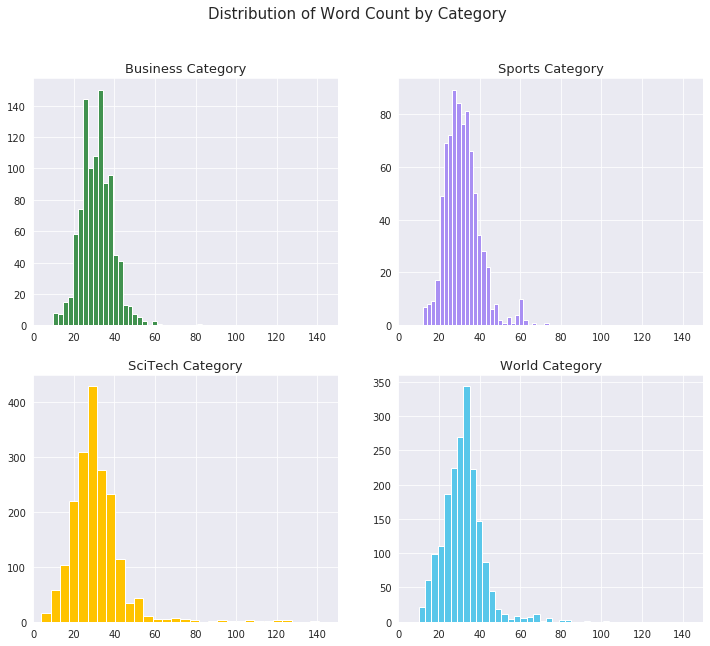

In [58]:
#Plot the distribution of word count by article

fig, ax = plt.subplots(2, 2, figsize = (12,10))
fig.suptitle('Distribution of Word Count by Category', fontsize=15)

bins = 30

ax[0, 0].hist(df_business['word_count'], bins = bins, color = '#41924F')
ax[0, 0].set_title('Business Category', fontsize = 13)
ax[0, 0].set_xlim(0, 150)

ax[1, 0].hist(df_scitech['word_count'], bins = bins, color = '#FFC300')
ax[1, 0].set_title('SciTech Category', fontsize = 13)
ax[1, 0].set_xlim(0, 150)

ax[0, 1].hist(df_sports['word_count'], bins = bins, color = '#a98ff3')
ax[0, 1].set_title('Sports Category', fontsize = 13)
ax[0, 1].set_xlim(0, 150)

ax[1, 1].hist(df_world['word_count'], bins = bins, color = '#59C7EA')
ax[1, 1].set_title('World Category', fontsize = 13)
ax[1, 1].set_xlim(0, 150)

plt.show()

In [59]:
#Creating the features (tf-idf weights) for the processed text

texts = df['clean_text'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts) #features
y = df['label_num'].values #target

print (X.shape)
print(y.shape)

(5590, 27657)
(5590,)


In [60]:
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
X.shape

(5590, 100)

# Preliminary model evaluation using default parameters

In [0]:
#Creating a dict of the models
model_dict = {'Dummy' : DummyClassifier(random_state=3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier()}

In [0]:
#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

In [63]:
#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)

,model_name,accuracy_score,precision_score,recall_score,f1_score
1,Stochastic Gradient Descent,0.79,0.80,0.75,0.77
2,Random Forest,0.76,0.77,0.72,0.73
4,AdaBoost,0.73,0.73,0.71,0.72
6,K Nearest Neighbor,0.68,0.68,0.65,0.66
5,Gaussian Naive Bayes,0.66,0.66,0.66,0.63
3,Decsision Tree,0.61,0.60,0.60,0.60
0,Dummy,0.29,0.26,0.26,0.26


In [64]:
#Hyperparameter tuning
#Gridsearch with 5-fold cross validation
#Warning this can take a long time!!!

#SGD
loss =  ['log']
penalty = ['l2','l1']
alpha = [1e-6, 1e-3, 1e-1, 1e0]
max_iter = [5, 1000, 10000]
tol = [None, 1e-3]
eta0 = [0.1, 0.001]

random_state = [3]

clf = SGDClassifier()

params = dict(loss=loss,
              penalty=penalty,
              alpha=alpha,
              max_iter=max_iter,
              tol=tol,
              random_state=random_state)

gridsearch = GridSearchCV(clf,
                          params,
                          cv = 5,
                          verbose = 1, 
                          n_jobs = -1)

sgd_best_model = gridsearch.fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.4min


KeyboardInterrupt: ignored

In [71]:
!pip install german

In [0]:
from german import preprocess

In [75]:
preprocess(['Johannes war einer von vielen guten Schülern.', 'Julia trinkt gern Tee.'], remove_stop=True)





  0%|          | 0/2 [00:00<?, ?it/s]



100%|██████████| 2/2 [00:00<00:00, 122.65it/s]



0it [00:00, ?it/s]

ConnectionError: ignored

In [76]:
pip install german-lemmatizer

In [81]:
from german_lemmatizer import lemmatize

lemmatize(
    ['Johannes war ein guter Schüler', 'Sabiene sang zahlreiche Lieder'],
    working_dir='*',
    chunk_size=10000,
    n_jobs=1,
    escape=False,
    remove_stop=False)

<generator object lemmatize at 0x7fd450fe1200>

In [0]:
import os
import pathlib
import shutil

import pytest

import german_lemmatizer


def test_lemma():
    res = german_lemmatizer.lemmatize(["Johannes war einer von vielen guten Schülern."])
    assert list(res) == ["Johannes sein einer von vielen gut Schüler."]


def test_lemma_mass():
    res = german_lemmatizer.lemmatize(
        ["Johannes war einer von vielen guten Schülern."] * 1000,
        chunk_size=400,
        n_jobs=2,
    )
    assert list(res) == ["Johannes sein einer von vielen gut Schüler."] * 1000


# def test_lemma_escape():
#     res = german_lemmatizer.lemmatize(
#         [
#             "Johannes war einer von vielen guten Schülern.",
#             """Peter war ein
#         Idiot.""",
#         ],
#         escape=True,
#     )
#     assert list(res) == [
#         "Johannes sein einer von vielen gut Schüler.",
#         """Peter sein ein
#         Idiot.""",
#     ]


# def test_lemma_stop():
#     res = german_lemmatizer.lemmatize(
#         ["Johannes war einer von vielen guten Schülern."], remove_stop=True
#     )
#     assert list(res) == ["Johannes gut Schüler."]